In this notebook I make a comment on a small section of chapter 5 in the book 

[Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control by Steven L. Brunton and J. Nathan Kutz](https://www.google.com/books/edition/Data_Driven_Science_and_Engineering/CYaEDwAAQBAJ?hl=en&gbpv=0)

The book is quite in the topics it covers, but it is very sloppy in the mathematical, statistical,  and computer science content. Nevertheless, I've found this section interesting. It is in chapter 6.2

To begin with, let's load some libraries and the dataset (provided by the book's authors):

In [1]:
from  scipy import io
import matplotlib.pyplot as plt
import numpy as np

cat_data_file = 'Data/catData.mat'
dog_data_file = 'Data/dogData.mat'

In [2]:
cat_data = io.loadmat(cat_data_file)['cat'].T
dog_data = io.loadmat(dog_data_file)['dog'].T

In [3]:
cat_data.shape

(80, 4096)

For instance, we have these kind of pictures of cats

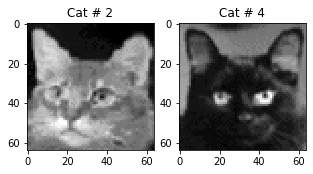

In [8]:
image_size = [int(np.sqrt(len(cat_data[0])))] * 2

# sample 2 cats from the  database 
sampled_cats = np.random.randint(10,size=2)

f, ax = plt.subplots(1,2, figsize=(5,10))
for image_index in range(2):

    ax[image_index].imshow(
        cat_data[sampled_cats[image_index]].reshape(*image_size).T,
        cmap='gray',
    )
    ax[image_index].set_title('Cat # {0}'.format(sampled_cats[image_index] + 1))
plt.show()


and this type of figures for dogs

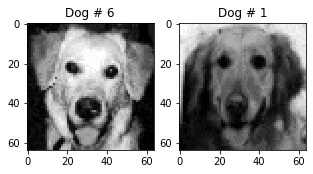

In [12]:

sampled_dogs = np.random.randint(10,size=2)
f, ax = plt.subplots(1,2, figsize=(5,10))
for image_index in range(2):
    ax[image_index].imshow(
        dog_data[sampled_dogs[image_index]].reshape(*image_size).T,
        cmap='gray',
    )
    ax[image_index].set_title('Dog # {0}'.format(sampled_dogs[image_index] + 1))
plt.show()

Let's combine the data sets

In [13]:
combined_data = np.concatenate((cat_data, dog_data))
print(np.shape(combined_data))

(160, 4096)


Now we label the data:

In [14]:
Y = np.ones([80,1])
Y = np.concatenate((Y,-Y),axis=0) 

>__Remark:__ we shall discuss later on the choice for the labels. Why $Y \in \{-1,1\}$? Why not $Y \in \{0,1\}$?

And before we move on, we split the data into a training and test set for later evaluation of the model:

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(combined_data, Y, test_size=0.4)

print("\n Shape of X Training set:",np.shape(X_train),"\n Shape of Y Training set:",np.shape(Y_train))


 Shape of X Training set: (96, 4096) 
 Shape of Y Training set: (96, 1)


>__Remark (on statistical design):__ the book does something that is not recommended at all from the point of view of statistical design of experiments; they "select" the training and test set by slicing the dataset matrix, namely, they pick as test set the last 20 individuals of the cat matrix, and last 20 individuals in the dog matrix. That is wrong and not recommended for the following reason: what if the data, before you obtained it, have been ordered in terms of color of the anima, or in weight, or in race of dog/cat? Could we be introducing any bias as we remove the last 20 individuals? Yes, we certainly could, specially if they have been ordered by intensity of their color. That's why we use the above code, which shuffles the dataset before splitting training and test set.

## Lasso

[Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) is a linear model, where the penalization/regularization is in $\ell^1$ norm. In this case, for a given dataset $(X,Y) = \left\{\left(X^{(i)},Y^{(i)}\right)\right\}_{1\leq i\leq N_{data}}$, we define

\begin{equation}\label{LASSO}
\text{Cost} =  \frac{1}{ (2 * N_{data})}  \Vert Y - Xw\Vert^2_{\ell^2} + \alpha * \Vert w\Vert_{\ell^1}.
\end{equation}
For using Lasso regression, we shall use the LAsso implementation on sklearn




In [16]:
from sklearn import linear_model

In [17]:
Lasso_correct_test = []
Lasso_correct_train = []

alpha_val = [4,2,1,.5,.25]

for alpha in alpha_val:
    Lasso = linear_model.Lasso(alpha=alpha)
    Lasso.fit(X_train, Y_train)

    predicted_train = Lasso.predict(X_train)>0
    true_train= Y_train>0
    Lasso_correct_train.append(np.sum(predicted_train==true_train.T)/len(true_train))
    

    predicted_test = Lasso.predict(X_test)>0
    true_test= Y_test>0
    Lasso_correct_test.append(np.sum(predicted_test==true_test.T)/len(true_test))
    
    # Coefficients
    W_Lasso = Lasso.coef_

/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028446452309980996, tolerance: 0.009595833333333331
  positive)


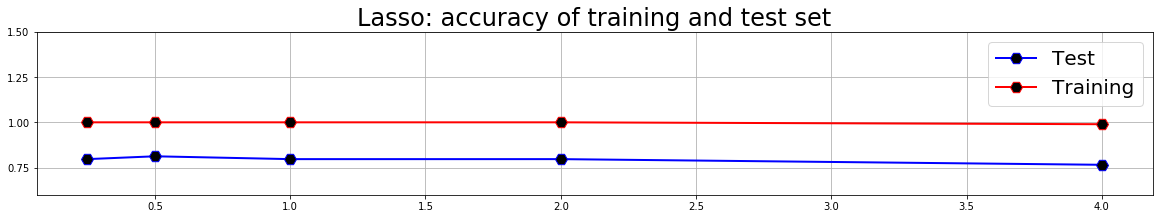

In [18]:
f, ax= plt.subplots(figsize=(20,3))
plt.rcParams.update({'font.size':20})
ax.plot(alpha_val,Lasso_correct_test,marker='H',markerfacecolor='black',markersize=12,color='b',lw=2,label="Test")
ax.plot(alpha_val,Lasso_correct_train,marker='H',markerfacecolor='black',markersize=12,color='r',lw=2,label="Training")
ax.set_ylim([.6, 1.5])
ax.legend()
ax.set_title("Lasso: accuracy of training and test set")
ax.grid(True)
plt.show()

In [19]:
v = np.squeeze(1*(predicted_test==true_test.T))
f, ax= plt.subplots(figsize=(20,5))
plt.rcParams.update({'font.size':20})

labelsy= ['Wrong','Correct']
ax.set_yticks([-1,1])
ax.set_yticklabels(labelsy)


ax.bar(np.arange(len(predicted_test)),2*v-1)
ax.set_xlabel("individuals")
ax.set_title("Lasso. Accuracy: {0}. alpha: {1}".format(Lasso_correct_test[-1],alpha_val[-1]) )
ax.grid(True)
plt.show()

Now, let's take a look at the coefficients of the weight matrix:

In [20]:
## First let's flat out this matrix
W_Lasso_flat =W_Lasso.flatten(order='F') 

In [21]:
f, ax= plt.subplots(figsize=(20,5))
plt.rcParams.update({'font.size':20})
ax.set_title("Lasso: coefficients of weight matrix" )
ax.bar(np.arange(len(W_Lasso_flat)), W_Lasso_flat/np.max(W_Lasso_flat),width=10)
ax.grid(True)
plt.show()

## Least square regression and Ridge Regression

Let's compare it with simple regression, which can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)
. In this case, for a given dataset $(X,Y) = \left\{\left(X^{(i)},Y^{(i)}\right)\right\}_{1\leq i\leq N_{data}}$, we define

\begin{align}\label{regression} \text{Cost} =  \frac{1}{ (2 * N_{data})}  \Vert Y - Xw\Vert^2_{\ell^2}.\end{align}

Whenever we add an $\ell^2$ regularization to this model we obtain what we call the [Ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) model:

\begin{align}\label{RIDGE} \text{Cost} =  \frac{1}{ (2 * N_{data})}  \Vert Y - Xw\Vert^2_{\ell^2} + \alpha * \Vert w\Vert_{\ell^1}.\end{align}


>__Remark:__ Even though \eqref{ridge} is the same as \eqref{regression} when $\alpha =0$ one should never use the later with $\alpha =0$; the main reason is that the methods to optimize both problems are totally different and more adequate for the case chosen.

In [22]:
from sklearn.linear_model import Ridge, LinearRegression

In [23]:
Ridge_correct_test = []
Ridge_correct_train = []

alpha_val = {0}#np.power(.99,np.arange(0,5))
for alpha in alpha_val:
    #clf_ridge = Ridge(alpha=alpha)
    clf_ridge=LinearRegression()
    clf_ridge.fit(X_train, Y_train)

    predicted_train_ridge = clf_ridge.predict(X_train)>0
    #print(predicted_train_ridge)
    true_train= Y_train>0
    
    Ridge_correct_train.append(np.sum(1*(predicted_train_ridge==true_train))/(len(true_train)))
    
    predicted_test_ridge = clf_ridge.predict(X_test)>0
    true_test= Y_test>0
    Ridge_correct_test.append(np.sum(1*(predicted_test_ridge==true_test))/(len(true_test)))
    
    # Coefficients
    W_Ridge = clf_ridge.coef_
    
print(Ridge_correct_test,Ridge_correct_train)

[0.796875] [1.0]


In [24]:
v = np.squeeze(1*(predicted_test_ridge==true_test))
f, ax= plt.subplots(figsize=(20,5))
plt.rcParams.update({'font.size':20})

labelsy= ['Wrong','Correct']
ax.set_yticks([-1,1])
ax.set_yticklabels(labelsy)



ax.bar(np.arange(len(predicted_test)),2*v-1)
ax.set_xlabel("individuals")
ax.set_title("Least squares. Accuracy: {0}. alpha: {1}".format(Ridge_correct_test[-1],alpha_val) )
ax.grid(True)
plt.show()

plt.show()

Now, let's take a look at the coefficients of the weight matrix:

In [25]:
## First let's flat out this matrix
W_Ridge_flat =W_Ridge.flatten(order='F') 

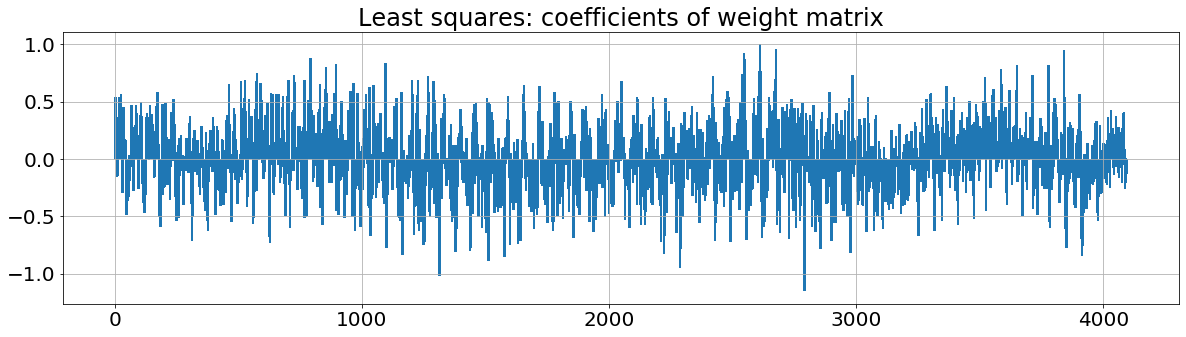

In [26]:
f, ax= plt.subplots(figsize=(20,5))
plt.rcParams.update({'font.size':20})
ax.set_title("Least squares: coefficients of weight matrix" )
ax.bar(np.arange(len(W_Ridge_flat)), W_Ridge_flat/np.max(W_Ridge_flat),width=10)
ax.grid(True)
plt.show()


<h1> <center> A remark on the labeling issue: is it indiferent to chose  $Y \in \{0,1\}$ or $Y \in \{-1,1\}$? </center> </h1> 

There is an interesting question that should be taken into account here: what would have changed if  we had chosen $Y \in \{0,1\}$ instead of $Y \in \{1,1\}$. 


It turns out that, in both Ridge and Lasso regression the labeling we choose  definitely matters.

The main reason is the following: what would happen if in any one of these penalized models we set $\alpha = +\infty$ (or, if you want to think as a limiting condition, as $\alpha \to +\infty$)? In this case the only feasible way to minimize \eqref{LASSO} or \eqref{RIDGE} is setting $W =0$. When that happens though, what is the impact in the  prediction model? In this case, all the points are predicted/labeled as 0. That said, it is clear that $\alpha$ is biasing the prediction, favoring one state (state 0) at the expense of the other (state 1).